### Municipalities
Municipalities in `SP`, `RJ` are the main focus.
They have the lowest velocity, and largest total orders.

In [1]:
import pandas as pd
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import seaborn as sns

from utils import read_customer_seller

In [2]:
def get_state(df: pd.DataFrame, state: str) -> pd.DataFrame:
    final_cols = []
    
    state_df = df[df["cus_state"] == state]
    
    state_df.drop_duplicates(subset=['order_id'])
    
    res = state_df[['cus_lat', 'cus_lng']].copy()
    res['delivery_hours'] = (state_df['order_delivered_customer_date'] - state_df['order_purchase_timestamp']).dt.total_seconds() / 3600
    res.columns = ['lat', 'lng', 'delivery_hours']
    return res

In [3]:
def read_gdf(state: str) -> gpd.GeoDataFrame:
    return gpd.read_file(f"../data/others/geojson/data/{state}.json")

In [4]:
def convert_gdf(df: pd.DataFrame) -> gpd.GeoDataFrame:
    geometry = gpd.points_from_xy(df.lng, df.lat)
    gdf = gpd.GeoDataFrame(
        df,
        geometry=geometry,
        crs="EPSG:4326"
    )
    return gdf

In [5]:
def summarize(df: pd.DataFrame, geo: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    df = gpd.sjoin(df, geo, predicate = "within", how='right')
    
    df = df.groupby(['NOME']).agg({
            'delivery_hours': 'mean',
            'index_left': 'count'
        }).reset_index()

    geo['delivery_hours'] = df['delivery_hours']
    geo['total_orders'] = df['index_left']
    
    return geo

In [6]:
def transform(df: pd.DataFrame, state: str) -> gpd.GeoDataFrame:
    df = get_state(df, state)
    df = convert_gdf(df)
    df = summarize(df,  read_gdf(state))
    
    return df

In [7]:
df = read_customer_seller()
df.head()

,order_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,cus_state,cus_lat,cus_lng,seller_state,seller_lat,seller_lng
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,SP,-23.574809,-46.587471,SP,-23.680114,-46.452454
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,BA,-12.169860,-44.988369,SP,-19.810119,-43.984727
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,GO,-16.746337,-48.514624,SP,-21.362358,-48.232976
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,RN,-5.767733,-35.275467,MG,-19.840168,-43.923299
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,SP,-23.675037,-46.524784,SP,-23.551707,-46.260979


### SP

In [8]:
sp = transform(df, 'SP')

In [9]:
sp.head()

,GEOCODIGO,NOME,UF,geometry,delivery_hours,total_orders
0,3544251,Rosana,SP,"POLYGON ((-52.94769 -22.47289, -52.88534 -22.4...",280.804254,35.0
1,3515350,Euclides da Cunha Paulista,SP,"POLYGON ((-52.77957 -22.60261, -52.7785 -22.59...",248.279889,5.0
2,3554300,Teodoro Sampaio,SP,"POLYGON ((-52.65639 -22.30333, -52.64531 -22.2...",258.418981,9.0
3,3541307,Presidente Epitácio,SP,"POLYGON ((-52.39141 -22.11421, -52.38586 -22.1...",274.157810,17.0
4,3528700,Marabá Paulista,SP,"POLYGON ((-52.28275 -22.2715, -52.27777 -22.26...",196.372037,3.0


In [24]:
sp.describe()

,delivery_hours,total_orders,delivery_rank
count,592.000000,645.000000,592.000000
mean,251.464489,63.613953,2.000000
std,97.620385,608.741313,1.417798
min,91.901944,0.000000,0.000000
25%,201.036767,2.000000,1.000000
50%,238.593356,7.000000,2.000000
75%,274.109661,23.000000,3.000000
max,1532.297500,15211.000000,4.000000


#### Delivery Inefficiency by Municipality (Quantile classification)
Although, with quantile classification it's hard to understand a pattern.

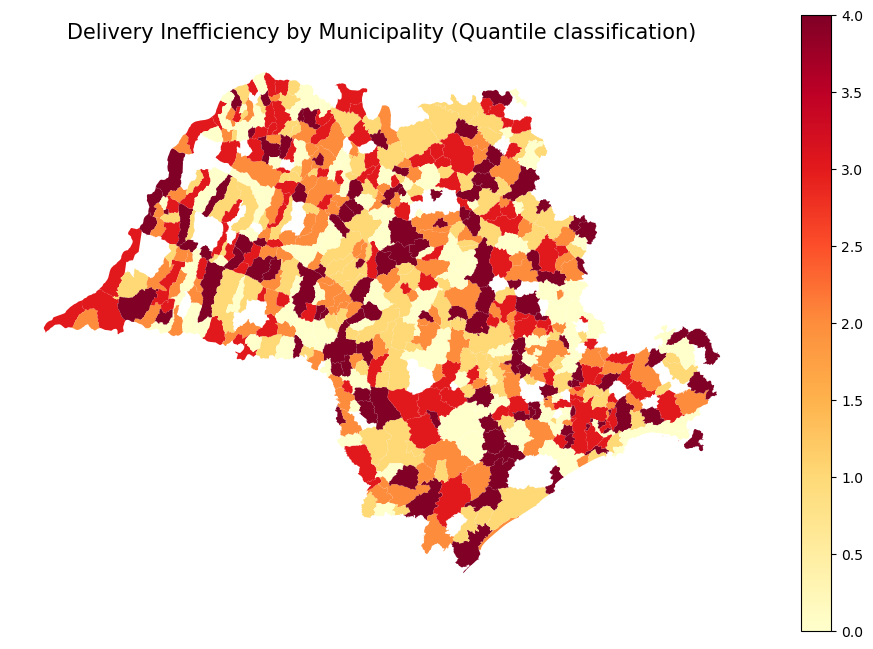

In [10]:
sp['delivery_rank'] = pd.qcut(sp['delivery_hours'], 
                                   q=5,
                                   labels= False)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# 2. Use 'quantiles' to ensure outliers don't dominate the color scale
# 'k=5' creates 5 equal-sized groups of municipalities
sp.plot(column='delivery_rank', 
              ax=ax, 
              legend=True, 
              # scheme='quantiles',  # Crucial for long-tail data
              # k=5, 
              cmap='YlOrRd', 
              # legend_kwds={'title': "Delivery Time Groups", 'loc': 'lower right'}
       )

ax.set_title('Delivery Inefficiency by Municipality (Quantile classification)', fontsize=15)
ax.axis('off')
plt.show()

#### Data Distribution (avg_delivery_hours)
`Box Plot` - Another long tail.

`Histogram` - Nearly bell shaped, most municipalities have less than 400 delivery hours.

I'll try to see which municipalites have those long delivery hours.

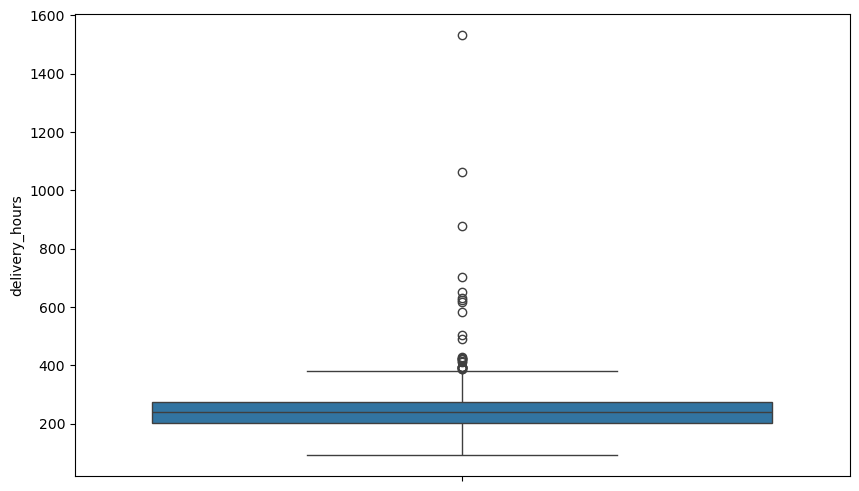

In [11]:
fig, ax = plt.subplots(figsize=(10, 6)) #

sns.boxplot(y='delivery_hours', data=sp, ax = ax)
plt.show()

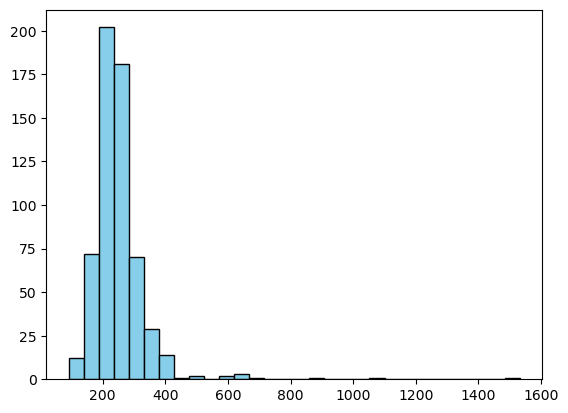

In [12]:
plt.hist(sp[['delivery_hours']] , bins=30, color='skyblue', edgecolor='black')
plt.show()

#### Scatter Plot
Check with a scatter plot to know that there is any realtion with total orders and average delivery hours.
They seems not related.

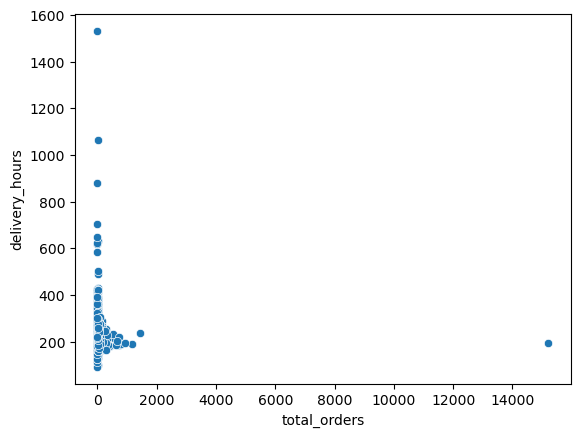

In [13]:
# Create a scatter plot
sns.scatterplot(data=sp, x="total_orders", y="delivery_hours")

# Display the plot
plt.show()

#### Delivery Inefficiency by Municipality 
Coloring municipalites which have longer than 400 dlivery hours.
I'll check the outlier municipalites on a map, to see it they are related by geolocation.

In [14]:
sp = sp.sort_values(by='total_orders', ascending=False)
sp.head(15)

,GEOCODIGO,NOME,UF,geometry,delivery_hours,total_orders,delivery_rank
572,3548104,Santo Antônio do Jardim,SP,"POLYGON ((-46.74672 -22.09239, -46.74343 -22.0...",192.908680,15211.0,0.0
100,3555802,Urânia,SP,"POLYGON ((-50.68303 -20.1924, -50.68057 -20.18...",235.318332,1420.0,2.0
204,3540309,Pontes Gestal,SP,"POLYGON ((-49.81174 -20.19456, -49.81269 -20.1...",191.687085,1154.0,0.0
554,3515186,Espírito Santo do Pinhal,SP,"POLYGON ((-46.8993 -22.24505, -46.89747 -22.20...",193.531612,926.0,0.0
528,3537602,Peruíbe,SP,"POLYGON ((-46.97975 -24.36979, -46.9785 -24.36...",188.337197,783.0,0.0
381,3550209,São Miguel Arcanjo,SP,"POLYGON ((-48.2058 -23.84859, -48.20342 -23.84...",184.253430,736.0,0.0
535,3537602,Peruíbe,SP,"POLYGON ((-46.90998 -24.38025, -46.91085 -24.3...",219.615613,713.0,1.0
563,3550803,São Sebastião da Grama,SP,"POLYGON ((-46.87109 -21.70825, -46.86962 -21.7...",203.867783,675.0,1.0
548,3501905,Amparo,SP,"POLYGON ((-46.86981 -22.58149, -46.86603 -22.5...",187.403904,612.0,0.0
287,3507456,Borebi,SP,"POLYGON ((-49.09534 -22.66602, -49.09195 -22.6...",214.691823,557.0,1.0


In [20]:
Q3 = sp['delivery_hours'].quantile(0.75)
Q1 = sp['delivery_hours'].quantile(0.25)
IQR = Q3 - Q1

upper_bound = Q3 + IQR * 1.5
outliers = sp['delivery_hours'] > upper_bound

highlight = sp[outliers].copy()


In [21]:
# Center point for Nashville
sao_paulo = [-23.56, -46.64]

# Create map
m = folium.Map(location=sao_paulo, zoom_start=6)

folium.Choropleth(
    geo_data=highlight,
    name='outlier municipalities',
    data=highlight,
    columns=['GEOCODIGO', 'delivery_hours'],
    key_on='feature.properties.GEOCODIGO',
    fill_color= 'Reds',
    fill_opacity=0.8,
    line_opacity=1,
).add_to(m)

# Create center column for the centroid of each district
highlight['center'] = highlight.geometry.to_crs(epsg=3578).centroid.to_crs(epsg=4326)

# Build markers and popups
for row in highlight.iterrows():
    row_values = row[1] 
    center_point = row_values['center']
    location = [center_point.y, center_point.x]
    popup = ('Name: ' + str(row_values['NOME']) 
             + ';  ' + 'waiting time: ' + str(row_values['delivery_hours'] / 24) 
             + ';  ' + 'total orders: ' + str(row_values['total_orders'])
    )
    marker = folium.Marker(location = location, popup = popup)
    marker.add_to(m)
    
# Display the map
folium.LayerControl().add_to(m)
display(m)

In [17]:
highlight = highlight.sort_values(by='total_orders', ascending=False)
highlight.head()

,GEOCODIGO,NOME,UF,geometry,delivery_hours,total_orders,delivery_rank,center
54,3526506,Lavínia,SP,"POLYGON ((-51.22507 -21.34126, -51.2203 -21.34...",429.396929,18.0,4.0,POINT (-51.03232 -21.14954)
474,3514908,Elias Fausto,SP,"POLYGON ((-47.38883 -22.98163, -47.38484 -22.9...",490.140040,7.0,4.0,POINT (-47.37012 -23.06986)
465,3557006,Votorantim,SP,"POLYGON ((-47.30773 -23.56112, -47.30906 -23.5...",1062.773889,4.0,4.0,POINT (-47.4061 -23.57938)
577,3513801,Diadema,SP,"POLYGON ((-46.64824 -23.72961, -46.63683 -23.7...",385.835139,4.0,4.0,POINT (-46.6109 -23.69646)
52,3528908,Mariápolis,SP,"POLYGON ((-51.24108 -21.7351, -51.24016 -21.73...",392.716667,4.0,4.0,POINT (-51.17116 -21.77874)


### SP - Finding 
The busiest municipalities have the healthy delivery time.

The most slowest municipalities have very low number of total orders, they might not have seperte local hub for delivery.


### RJ

In [18]:
rj = transform(df, 'RJ')
rj.head()

,GEOCODIGO,NOME,UF,geometry,delivery_hours,total_orders
0,3303807,Parati,RJ,"POLYGON ((-44.88096 -23.21548, -44.88305 -23.2...",396.401852,87.0
1,3304201,Resende,RJ,"POLYGON ((-44.80881 -22.4048, -44.80799 -22.40...",329.496782,12.0
2,3303807,Parati,RJ,"POLYGON ((-44.71912 -23.35896, -44.72038 -23.3...",420.002720,77.0
3,3303807,Parati,RJ,"POLYGON ((-44.71022 -23.20432, -44.70901 -23.2...",206.058690,7.0
4,3303807,Parati,RJ,"POLYGON ((-44.69299 -23.21618, -44.69271 -23.2...",589.093393,28.0


#### Data Distribution (avg_delivery_hours)
Box Plot - The mean delivery time is larger in RJ, but the sd is slightly smaller. No long tail.

The average delivery time in SP is better than in RJ. But, there are less suprise delay in RJ. 

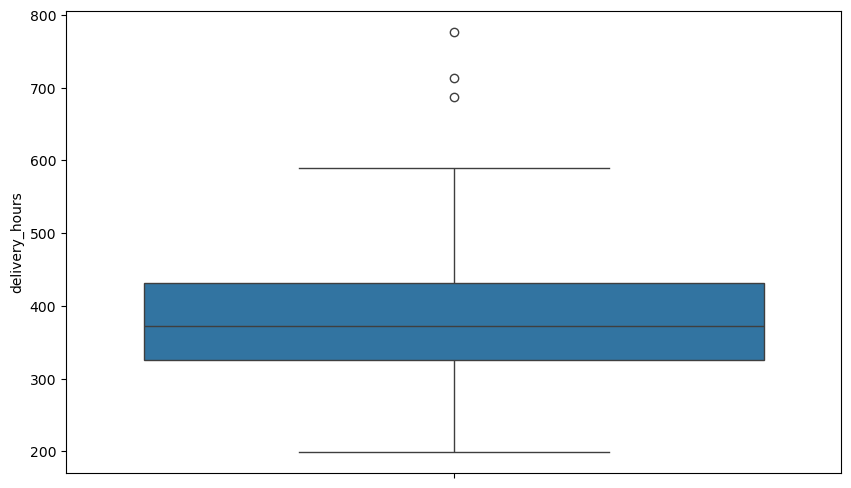

In [22]:
fig, ax = plt.subplots(figsize=(10, 6)) #

sns.boxplot(y='delivery_hours', data=rj, ax = ax)
plt.show()

In [23]:
rj.describe()

,delivery_hours,total_orders
count,92.000000,92.000000
mean,385.177499,135.510870
std,95.652102,695.103368
min,198.990107,1.000000
25%,326.060285,11.500000
50%,371.849094,23.500000
75%,431.635340,61.250000
max,776.469206,6640.000000


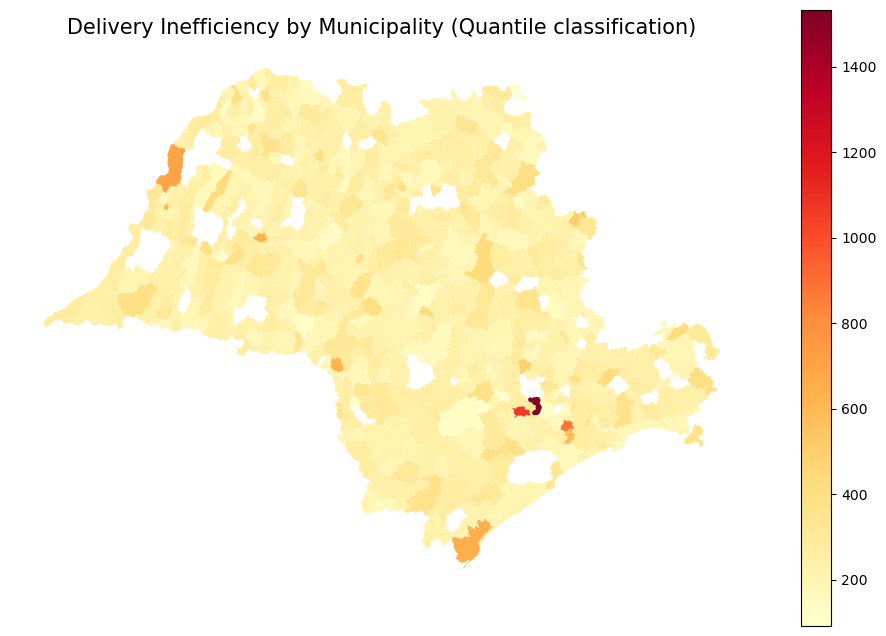

In [25]:
# sp['delivery_rank'] = pd.qcut(sp['delivery_hours'], 
#                                    q=5,
#                                    labels= False)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# 2. Use 'quantiles' to ensure outliers don't dominate the color scale
# 'k=5' creates 5 equal-sized groups of municipalities
sp.plot(column='delivery_hours', 
              ax=ax, 
              legend=True, 
              cmap='YlOrRd', 
       )

ax.set_title('Delivery Inefficiency by Municipality (Quantile classification)', fontsize=15)
ax.axis('off')
plt.show()

In [26]:
rj = rj.sort_values(by='delivery_hours', ascending = False)
rj.head(10)

,GEOCODIGO,NOME,UF,geometry,delivery_hours,total_orders
58,3302601,Mangaratiba,RJ,"POLYGON ((-43.96746 -22.94467, -43.96701 -22.9...",776.469206,7.0
23,3303807,Parati,RJ,"POLYGON ((-44.62968 -23.06258, -44.62865 -23.0...",713.311852,3.0
86,3302908,Miguel Pereira,RJ,"POLYGON ((-43.65287 -22.61475, -43.6458 -22.60...",687.686424,8.0
4,3303807,Parati,RJ,"POLYGON ((-44.69299 -23.21618, -44.69271 -23.2...",589.093393,28.0
89,3304557,Rio de Janeiro,RJ,"POLYGON ((-43.5139 -23.06614, -43.51449 -23.06...",545.140139,4.0
13,3303807,Parati,RJ,"POLYGON ((-44.67109 -23.2399, -44.6703 -23.238...",534.032639,10.0
32,3303807,Parati,RJ,"POLYGON ((-44.58382 -23.20059, -44.58226 -23.1...",499.781875,52.0
5,3303807,Parati,RJ,"POLYGON ((-44.69407 -23.16124, -44.69502 -23.1...",495.683544,29.0
25,3303807,Parati,RJ,"POLYGON ((-44.62449 -23.05865, -44.62304 -23.0...",475.903472,6.0
18,3303807,Parati,RJ,"POLYGON ((-44.6594 -23.18537, -44.65849 -23.18...",473.108773,12.0


In [27]:
rj = rj.sort_values(by='total_orders', ascending = False)
rj.head(10)

,GEOCODIGO,NOME,UF,geometry,delivery_hours,total_orders
67,3302601,Mangaratiba,RJ,"POLYGON ((-43.92307 -22.98733, -43.92354 -22.9...",353.380467,6640.0
47,3302601,Mangaratiba,RJ,"POLYGON ((-44.13846 -23.04339, -44.13863 -23.0...",351.195705,844.0
49,3302601,Mangaratiba,RJ,"POLYGON ((-44.13059 -23.03815, -44.12899 -23.0...",337.255593,433.0
77,3304557,Rio de Janeiro,RJ,"POLYGON ((-43.79456 -22.91724, -43.79116 -22.9...",444.067745,380.0
14,3303807,Parati,RJ,"POLYGON ((-44.67766 -23.11447, -44.67707 -23.1...",360.136447,258.0
24,3300100,Angra dos Reis,RJ,"POLYGON ((-44.63307 -22.90495, -44.63191 -22.9...",362.244917,257.0
54,3302601,Mangaratiba,RJ,"POLYGON ((-44.0442 -22.98778, -44.04149 -22.98...",362.162931,241.0
36,3303807,Parati,RJ,"POLYGON ((-44.55716 -23.22393, -44.55649 -23.2...",413.971732,238.0
91,3302858,Mesquita,RJ,"POLYGON ((-43.41595 -22.76434, -43.4077 -22.77...",395.284424,229.0
48,3306107,Valença,RJ,"POLYGON ((-44.18907 -22.24026, -44.18458 -22.2...",468.589080,145.0


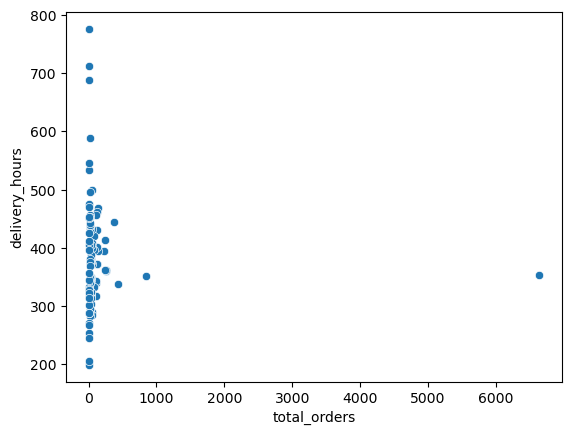

In [28]:
# Create a scatter plot
sns.scatterplot(data=rj, x="total_orders", y="delivery_hours")

# Display the plot
plt.show()

In [31]:
highlight = rj.sort_values(by='delivery_hours', ascending = False).head(10)

In [33]:
# Center point for Nashville
mangaratiba = [-22.9414046,-44.0458212]

# Create map
m = folium.Map(location=sao_paulo, zoom_start=6)

folium.Choropleth(
    geo_data=highlight,
    name='outlier municipalities',
    data=highlight,
    columns=['GEOCODIGO', 'delivery_hours'],
    key_on='feature.properties.GEOCODIGO',
    fill_color= 'Reds',
    fill_opacity=0.8,
    line_opacity=1,
).add_to(m)

# Create center column for the centroid of each district
highlight['center'] = highlight.geometry.to_crs(epsg=3578).centroid.to_crs(epsg=4326)

# Build markers and popups
for row in highlight.iterrows():
    row_values = row[1] 
    center_point = row_values['center']
    location = [center_point.y, center_point.x]
    popup = ('Name: ' + str(row_values['NOME']) 
             + ';  ' + 'waiting time: ' + str(row_values['delivery_hours'] / 24) 
             + ';  ' + 'total orders: ' + str(row_values['total_orders'])
    )
    marker = folium.Marker(location = location, popup = popup)
    marker.add_to(m)
    
# Display the map
folium.LayerControl().add_to(m)
display(m)

### RJ - Finding
The main municipality `Mangaratiba` have the largest number of total orders and have the most efficiency delivery hub.

As in SP, the suffering areas have low number of total orders. 
And, in most case in RJ, they are island, which might need special kind of transportation to get there.